In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import matplotlib
import os
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LinearRegression, Ridge
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import numpy as np
import xarray as xr
import scipy   
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.model_selection import KFold
from scipy import io
from scipy import stats
import pickle
import tensorflow
import numpy as np
import pyaldata
from pyaldata import *
import keras
from tensorflow.keras.models import Sequential
import keras.models
import mgplvm as mgp # to clone 

torch.cuda.is_available()

np.random.seed(0)
torch.manual_seed(0)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU

device='cpu'

data_dir = "/home/md5218/THESIS/intro_pyaldata/bGPFA/"
fname_data = os.path.join(data_dir, "Mihili_RT_FF_2014-02-14_2.mat")
data=mat2dataframe(fname_data, shift_idx_fields=True)
binsize = 20 # binsize in ms

loading


In [2]:
from Neural_Decoding_folder import *
from Neural_Decoding_folder.Neural_Decoding.preprocessing_funcs import get_spikes_with_history
#Import metrics
from Neural_Decoding_folder.Neural_Decoding.metrics import get_R2
from Neural_Decoding_folder.Neural_Decoding.metrics import get_rho
#Import decoder functions
from Neural_Decoding_folder.Neural_Decoding.decoders import LSTMDecoder, DenseNNRegression

In [3]:
from keras.layers import Dense, LSTM
from keras.utils import np_utils
import keras
keras_v1=int(keras.__version__[0])<=1
keras_v1
import tensorflow as tf
from tensorflow.keras.models import Model

In [4]:
data_dir = "/home/md5218/THESIS/intro_pyaldata/bGPFA/"
fname_data = os.path.join(data_dir, "Mihili_RT_FF_2014-02-14_2.mat")
data=mat2dataframe(fname_data, shift_idx_fields=True)
binsize = 20 # binsize in ms
data_dir = "/home/md5218/THESIS/intro_pyaldata/bGPFA/"
fname_model = os.path.join(data_dir, "model")

In [5]:
model=torch.load(fname_model)

In [6]:
X = model.lat_dist.lat_mu.detach().cpu().numpy()[0, ...]

In [7]:
X.shape

(100000, 40)

In [8]:
#for this data frame each trial =  4 (x,y) target reaching task 
""" target of each trial stored in target_center - must correct them """
data.target_center[0].shape #4 targets in space, 2(x,y)
for trial in range (0, 741): 
    targets=data.target_center[trial]
    targets=targets.flatten()[[0, 2, 4, 6, 1, 3, 5, 7]].reshape(-1, 2)
    data.target_center[trial]=targets

/tmp/ipykernel_1177695/2969094151.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.target_center[trial]=targets


In [9]:
""" center signal """
data=center_signal(data, 'pos')
"""1. remove low firing neurons - M1 has higher firing rates """
print("original M1: ", data.M1_spikes[0].shape) #22 neurons 
print("original PMd: ", data.PMd_spikes[0].shape) #94 neurons 
data_1 = remove_low_firing_neurons(data, "M1_spikes",  5)
data_1 = remove_low_firing_neurons(data, "PMd_spikes", 2)
print("post removal M1:  ", data_1.M1_spikes[0].shape) #22 neurons - all contributing 
print("post removal PMd:  ", data_1.PMd_spikes[0].shape) #55 neurons - reduced 
"""2. merge neurons from motor and premotor cortices """
data_2 = merge_signals(data_1, ["M1_spikes", "PMd_spikes"], "both_spikes")

print(f"Merging M1 and PMd gives {data_1.M1_spikes[0].shape[1]} + {data_1.PMd_spikes[0].shape[1]} = {data_2.both_spikes[0].shape[1]} neurons")

original M1:  (2576, 22)
original PMd:  (2576, 94)
post removal M1:   (2576, 22)
post removal PMd:   (2576, 55)
Merging M1 and PMd gives 22 + 55 = 77 neurons


/home/md5218/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/md5218/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [10]:
# try downsampling data ... to use more a longer duration on the gpu 
data=data_2
data=combine_time_bins(data, 2)
data.both_spikes[0].shape #(1288, 77)

def concat_trials(trial_data, signal, trial_indices=None):
    """
    Concatenate signal from different trials in time

    Parameters
    ----------
    trial_data : pd.DataFrame
        data in trial_data format
    signal : str
        name of the field to concatenate
    trial_indices : array-like of ints
        indices of the trials we want to get the signal from

    Returns
    -------
    np.array of the signal in the selected trials
    stacked on top of each other
    """
    if trial_indices is None:
        return np.concatenate(trial_data[signal].values, axis=0)
    else:
        return np.concatenate(trial_data.loc[trial_indices, signal].values, axis=0)

In [11]:
    
Y=concat_trials(data, 'both_spikes')
Y=np.array(np.transpose(Y[1:100001, :])) #(77, 328429), or only considering 30000 samples to see if it works 
num_neurons=Y.shape[0]
T_all_trials=Y.shape[1]
Y=np.reshape(Y, (1, num_neurons, T_all_trials))
Y.shape #(1, 77, 328429) #(1, 77, 164034) downsampling


(1, 77, 100000)

In [12]:
locs=concat_trials(data, 'pos')
locs=np.array(locs[1:100001, :]) #(2, 328429), only considering 30000 thousand positions (30000, 2)
T_all_trials=locs.shape[1]
locs.shape #(328429, 2)

vel=concat_trials(data, 'vel')
vel=np.array(vel[1:100001, :]) #(2, 328429), only considering 30000 thousand positions (30000, 2)
T_all_trials=vel.shape[1]
vel.shape #(328429, 2)

(100000, 2)

# LSTM

USING INFERRED RATES 

In [13]:
model_lstm=LSTMDecoder(units=400, dropout=0, num_epochs=5)

In [32]:
Ypreds = [] # decode from the inferred firing rates (this is a non-linear decoder from latents)
query = model.lat_dist.lat_mu.detach().transpose(-1, -2).to(device)  # (ntrial, d_fit, T)
for i in range(10): # loop over mc samples to avoid memory issues
    Ypred = model.svgp.sample(query, n_mc=100, noise=False)
    Ypred = Ypred.detach().mean(0).cpu().numpy()  # (ntrial x n x T)
    Ypreds.append(Ypred)
Ypred = np.mean(np.array(Ypreds), axis = (0,1)).T # T x n ----- all trials concatenated ????? 

In [33]:
"""To do K-fold cross validation splitting dataset by trials need to use the extended matrix:
trials x time x neurons*6 --- but then when concatenating trials for training & testing, it becomes: 
all time x neurons*6 ---> reshape to be all time x neurons x 6 (where 6 is time bins before, current and after)

only this format can be processed by LSTMRegression - as defined by Glaser et al. """


bins_before=5

all_rates_hist_matrix=[[]]
for t in range (bins_before+1, len(Ypred)): 
    rates_hist=[]
    rates_hist.append(Ypred[t, :])
    rates_hist.append(Ypred[t-1, :])
    rates_hist.append(Ypred[t-2, :])
    rates_hist.append(Ypred[t-3, :])
    rates_hist.append(Ypred[t-4, :])
    rates_hist.append(Ypred[t-5, :])
    rates_hist=np.reshape(rates_hist, (1,(bins_before+1)*77))
    all_rates_hist_matrix.append(rates_hist)
all_rates_hist_matrix.pop(0)
len(all_rates_hist_matrix) #99994 
#len(np.transpose(X_hist_matrix)) #180
all_rates_hist_matrix=np.squeeze(all_rates_hist_matrix)
all_rates_hist_matrix=np.array(all_rates_hist_matrix)
all_rates_hist_matrix.shape #(99994, 180)

(99994, 462)

In [34]:
all_rates_hist_matrix.shape
type(all_rates_hist_matrix)
all_rates_hist=np.reshape(all_rates_hist_matrix,( len(all_rates_hist_matrix), 77, 6))
# all_rates_hist.shape # (99994, 77, 6)

In [35]:
pos_for_history=[[]]
pos_row=locs[6:,:]
pos_for_history.append(pos_row)
pos_for_history.pop(0)
len(pos_for_history) #1
#len(np.transpose(pos_for_history)) #2
locs_hist=pos_for_history[0][:, :]
locs_hist.shape #(99990, 2)

type(locs_hist)
locs_hist.shape

vel_for_history=[[]]
vel_row=vel[6:,:]
vel_for_history.append(vel_row)
vel_for_history.pop(0)
len(vel_for_history) #1
#len(np.transpose(pos_for_history)) #2
vel_hist=vel_for_history[0][:, :]
vel_hist.shape #(99990, 2)

type(vel_hist)
vel_hist.shape

(99994, 2)

In [ ]:
scores=[]
train=[]
test=[]
#this splits into trials but beforehand all concatenated - so use both_rates_with_history
for (training, testing) in KFold(10, shuffle=True).split(all_rates_hist[0:99990, :, :]): 
    X_train = all_rates_hist[training, :, :]
    X_test = all_rates_hist[testing, :, :] 
    Y_train = vel_hist[training, :]
    Y_test = vel_hist[testing, :]
    #testing_vector.append(testing)
    #model = LSTMDecoder(units=400,dropout=0,num_epochs=5)   #no need to redefine at iteration 
    model_lstm.fit(X_train, Y_train)
    y_test_predicted_lstm=model_lstm.predict(X_test)
    scores.append(get_R2(Y_test, y_test_predicted_lstm))
    train.append(training)
    test.append(testing)
scores

#          scores for VELOCITY  
"""
[array([0.67458964, 0.69450486]),
 array([0.71187648, 0.70929647]),
 array([0.70616988, 0.73769621]),
 array([0.6934575 , 0.70561365]),
 array([0.72918208, 0.71832984]),
 array([0.7130399 , 0.73695897]),
 array([0.70823955, 0.69760622]),
 array([0.71779354, 0.70952372]),
 array([0.70490636, 0.72020643]),
 array([0.71166133, 0.73535081])]
"""

#          scores for POSITION  
"""
[array([0.78346572, 0.80591424]),
 array([0.78804159, 0.83273549]),
 array([0.77899036, 0.79414443]),
 array([0.784104  , 0.79246462]),
 array([0.77010774, 0.7332966 ]),
 array([0.76141254, 0.77781722]),
 array([0.71338434, 0.79986766]),
 array([0.72667229, 0.78971629]),
 array([0.79502361, 0.82383741]),
 array([0.79806248, 0.8296802 ])]
"""

In [36]:
cv_scores_vel_x_rates_LSTM=[0.67458964, 0.71187648, 0.70616988, 0.6934575 , 0.72918208, 
                       0.7130399 , 0.70823955, 0.71779354, 0.70490636, 0.71166133]
cv_scores_vel_y_rates_LSTM=[0.69450486, 0.70929647, 0.73769621, 0.70561365, 0.71832984, 
                       0.73695897, 0.69760622, 0.70952372, 0.72020643, 0.73535081]
cv_scores_pos_x_rates_LSTM=[0.78346572, 0.78804159, 0.77899036, 0.784104  , 0.77010774, 
                       0.76141254, 0.71338434, 0.72667229, 0.79502361, 0.79806248]
cv_scores_pos_y_rates_LSTM=[0.80591424, 0.83273549, 0.79414443, 0.79246462, 0.7332966, 
                       0.77781722, 0.79986766, 0.78971629, 0.82383741, 0.8296802 ]

In [37]:
rates_LSTM = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_scores_vel_x_rates,
     'Vel_y': cv_scores_vel_y_rates,
     'Pos_x': cv_scores_pos_x_rates ,
     'Pos_y': cv_scores_pos_y_rates ,
    }
pd.set_option('display.max_columns', None)
cv_scores_LSTM_rates = pd.DataFrame(data=rates_LSTM)
cv_scores_LSTM_rates

fig, ax = plt.subplots(figsize = (7, 4))
boxplot_LSTM_rates = cv_scores_LSTM_rates.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_LSTM_rates.set_title('10-fold CV, scores - LSTM, \n using the Inferred Rates P(F|X,Y) as an Input', fontsize=13)
boxplot_LSTM_rates.set_ylim([0.67, 1])
boxplot_LSTM_rates.set_xlabel('Output Field', fontsize=13)
plt.savefig('bGPFA_LSTM_scores_rates.jpeg')


NameError: name 'cv_scores_vel_x_rates' is not defined

USING INFERRED LATENTS 

In [14]:
X = model.lat_dist.lat_mu.detach().cpu().numpy()[0, ...]

In [15]:
"""To do K-fold cross validation splitting dataset by trials need to use the extended matrix:
trials x time x neurons*6 --- but then when concatenating trials for training & testing, it becomes: 
all time x neurons*6 ---> reshape to be all time x neurons x 6 (where 6 is time bins before, current and after)

only this format can be processed by LSTMRegression - as defined by Glaser et al. """

bins_before=5

all_latents_hist_matrix=[[]]
for t in range (bins_before+1, len(X)): 
    latents_hist=[]
    latents_hist.append(X[t, :])
    latents_hist.append(X[t-1, :])
    latents_hist.append(X[t-2, :])
    latents_hist.append(X[t-3, :])
    latents_hist.append(X[t-4, :])
    latents_hist.append(X[t-5, :])
    latents_hist=np.reshape(latents_hist, (1,(bins_before+1)*40))
    all_latents_hist_matrix.append(latents_hist)
all_latents_hist_matrix.pop(0)
len(all_latents_hist_matrix) #99994 
#len(np.transpose(X_hist_matrix)) #180
all_latents_hist_matrix=np.squeeze(all_latents_hist_matrix)
all_latents_hist_matrix=np.array(all_latents_hist_matrix)
all_latents_hist_matrix.shape #(99994, 180)

(99994, 240)

In [16]:
all_latents_hist_matrix.shape
type(all_latents_hist_matrix)
all_latents_hist=np.reshape(all_latents_hist_matrix,( len(all_latents_hist_matrix), 40, 6))

In [ ]:
scores=[]
train=[]
test=[]
#this splits into trials but beforehand all concatenated - so use both_rates_with_history
for (training, testing) in KFold(10, shuffle=True).split(all_latents_hist[0:99990, :, :]): 
    X_train = all_latents_hist[training, :, :]
    X_test = all_latents_hist[testing, :, :] 
    Y_train = vel_hist[training, :]
    Y_test = vel_hist[testing, :]
    #testing_vector.append(testing)
    #model = LSTMDecoder(units=400,dropout=0,num_epochs=5)   #no need to redefine at iteration 
    model_lstm.fit(X_train, Y_train)
    y_test_predicted_lstm=model_lstm.predict(X_test)
    scores.append(get_R2(Y_test, y_test_predicted_lstm))
    train.append(training)
    test.append(testing)
scores

#          scores for VELOCITY  
"""
[array([0.92140937, 0.91351966]),
 array([0.92368591, 0.91452149]),
 array([0.91340234, 0.90511381]),
 array([0.91316433, 0.90971211]),
 array([0.91654864, 0.91054961]),
 array([0.91306687, 0.90250338]),
 array([0.92118182, 0.91143649]),
 array([0.92222493, 0.91987674]),
 array([0.92290897, 0.91372856]),
 array([0.9133583, 0.9117656])]
"""

#          scores for POSITION  
"""
[array([0.98197556, 0.98451036]),
 array([0.98131631, 0.98473229]),
 array([0.98224821, 0.98313725]),
 array([0.98336054, 0.98607687]),
 array([0.98361033, 0.98458969]),
 array([0.98121074, 0.984394  ]),
 array([0.9824812 , 0.98445498]),
 array([0.98194076, 0.98483623]),
 array([0.98345611, 0.98325001]),
 array([0.98049719, 0.98377365])]
"""

In [ ]:
cv_scores_vel_x_latents=[0.92140937, 0.92368591, 0.91340234, 0.91316433, 0.91654864, 
                         0.91306687, 0.92118182, 0.92222493, 0.92290897, 0.9133583]
cv_scores_vel_y_latents=[0.91351966, 0.91452149, 0.90511381, 0.90971211, 0.91054961, 
                         0.90250338, 0.91143649, 0.91987674, 0.91372856, 0.9117656]
cv_scores_pos_x_latents=[0.98197556, 0.98131631, 0.98224821, 0.98336054, 0.98361033, 
                         0.98121074, 0.9824812 , 0.98194076, 0.98345611, 0.98049719]
cv_scores_pos_y_latents=[0.98451036, 0.98473229, 0.98313725, 0.98607687, 0.98458969, 
                         0.984394  , 0.98445498, 0.98483623, 0.98325001, 0.98377365]

In [ ]:
def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True, showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

cv_rates_bGPFA_LSTM = [cv_scores_pos_x_rates,cv_scores_pos_y_rates, cv_scores_vel_x_rates,cv_scores_vel_y_rates]
cv_latents_bGPFA_LSTM = [cv_scores_pos_x_latents,cv_scores_pos_y_latents, cv_scores_vel_x_latents,cv_scores_vel_y_latents]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_rates_bGPFA_LSTM, 'red', 'tan')
bp2 = box_plot(cv_latents_bGPFA_LSTM, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['F=CX', 'X'], fontsize=13)
ax.set_ylim(0.65, 0.995)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: LSTM based on the bGPFA-inferred latents \n and on the rates calculated from these', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('APPENDIX_LSTM_scores_bGPFA_XvsF.jpeg')

In [ ]:
latents_LSTM = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_scores_vel_x_latents,
     'Vel_y': cv_scores_vel_y_latents,
     'Pos_x': cv_scores_pos_x_latents,
     'Pos_y': cv_scores_pos_y_latents,
    }
pd.set_option('display.max_columns', None)
cv_scores_LSTM_latents = pd.DataFrame(data=latents_LSTM)
cv_scores_LSTM_latents

fig, ax = plt.subplots(figsize = (7, 4))
boxplot_LSTM_latents = cv_scores_LSTM_latents.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_LSTM_latents.set_title('10-fold CV, scores - LSTM, \n using the Inferred Latents P(X|Y) as an Input', fontsize=13)
boxplot_LSTM_latents.set_ylim([0.67, 1])
boxplot_LSTM_latents.set_xlabel('Output Field', fontsize=13)
plt.savefig('bGPFA_LSTM_scores_latents.jpeg')

In [ ]:
mean_scores_LSTM={'CV':['AVERAGE SCORE'], 
     'Rates-vel_x': np.mean(cv_scores_vel_x_rates),
     'Rates-vel_y': np.mean(cv_scores_vel_y_rates),
     'Rates-pos_x': np.mean(cv_scores_pos_x_rates),
     'Rates-pos_y': np.mean(cv_scores_pos_y_rates),
     'Latents-vel_x': np.mean(cv_scores_vel_x_latents),
     'Latents-vel_y': np.mean(cv_scores_vel_y_latents),
     'Latents-pos_x': np.mean(cv_scores_pos_x_latents),
     'Latents-pos_y': np.mean(cv_scores_pos_y_latents),
    }
pd.set_option('display.max_columns', None)
cv_scores_LSTM_mean = pd.DataFrame(data=mean_scores_LSTM)
cv_scores_LSTM_mean

In [ ]:
def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True, showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

# scores using the firing rates from the data 

cv_vel_x_rates=[0.95597108,0.95001408,0.95340578,0.94936236,0.95595663,0.95581072,0.95881756,
                  0.95120518,0.95268704,0.95114964]
cv_vel_y_rates=[0.95097876, 0.94883948, 0.95012732, 0.94690591, 0.95220971, 0.94763706, 0.95055216, 
                  0.94630818, 0.95205219, 0.94769666]
cv_pos_x_rates=[0.97745602, 0.97567137, 0.97580711, 0.97434582, 0.9749096 , 0.97575527, 0.97359311, 
                   0.97334644, 0.97756795, 0.97686266]
cv_pos_y_rates=[0.97748025, 0.97849039, 0.97772142, 0.9791986, 0.97875781, 0.97805503, 0.97772923,
                   0.97805531, 0.97994865, 0.9813002]

cv_rates_LSTM = [cv_pos_x_rates,cv_pos_y_rates, cv_vel_x_rates,cv_vel_y_rates]
cv_latents_LSTM = [cv_scores_pos_x_latents,cv_scores_pos_y_latents, cv_scores_vel_x_latents,cv_scores_vel_y_latents]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_latents_LSTM, 'red', 'tan')
bp2 = box_plot(cv_rates_LSTM, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['bGPFA', 'Firing Rates'], fontsize=13)
ax.set_ylim(0.90, 0.995)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: LSTM based on the rates \n and the latents found by bGPFA', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('LSTM_scores_bGPFAvsRates.jpeg')

In [ ]:
cv_vel_x_pcs=[0.96255548, 0.95973464, 0.9598874 , 0.96243119, 0.96090319, 0.96223392, 0.96197628, 
                          0.96100978, 0.96276608, 0.96212506]
cv_vel_y_pcs=[0.95776219, 0.95696231, 0.95811964, 0.95990905, 0.9609399 , 0.95951015, 
                          0.95792669, 0.95902386, 0.96056491, 0.9569561]
cv_pos_x_pcs=[0.97974532, 0.97808459, 0.97886193, 0.97954095, 0.97861696, 0.97881041, 
                          0.97956185, 0.98063652, 0.97905856, 0.97960072]
cv_pos_y_pcs=[0.9807244 , 0.98005306, 0.98177455, 0.98014698, 0.98126859, 0.98143323, 
                          0.98209167, 0.9821061 , 0.9820066 , 0.98064705]

cv_pcs_LSTM = [cv_pos_x_pcs,cv_pos_y_pcs, cv_vel_x_pcs,cv_vel_y_pcs]
cv_latents_LSTM = [cv_scores_pos_x_latents,cv_scores_pos_y_latents, cv_scores_vel_x_latents,cv_scores_vel_y_latents]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_latents_LSTM, 'red', 'tan')
bp2 = box_plot(cv_pcs_LSTM, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['bGPFA', 'PCA'], fontsize=13)
ax.set_ylim(0.90, 0.995)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: LSTM based on the latents \n found by PCA and on those inferred by bGPFA', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('LSTM_scores_bGPFAvsPCA.jpeg')

COMPUTING PREDICTIONS

In [17]:
# Plot predictions 
neural_data= Ypred # T all trials x N
y=locs

#Doing decoding with history ---- LSTM takes into consideration previous time samples 

bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

Y = get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

X_train=Y[10:90000, :, :] # first elements were NaNs 
y_train=y[10:90000, :] # first elements were NaNs 
X_test=Y[90000:99999, :, :]
y_test=y[90000:99999, :]

#Fit model - Train model
model_lstm.fit(X_train, y_train)

#Test model 
y_test_predicted_lstm_rates=model_lstm.predict(X_test)
R2s_lstm_test_rates=get_R2(y_test, y_test_predicted_lstm_rates)
print('R2s:', R2s_lstm_test_rates)

NameError: name 'Ypred' is not defined

In [18]:
# Plot predictions 
neural_data= X # T all trials x N
y=locs

#Doing decoding with history ---- LSTM takes into consideration previous time samples 

bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

Y = get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

X_train=Y[10:90000, :, :] # first elements were NaNs 
y_train=y[10:90000, :] # first elements were NaNs 
X_test=Y[90000:99999, :, :]
y_test=y[90000:99999, :]

#Fit model - Train model
model_lstm.fit(X_train, y_train)

#Test model 
y_test_predicted_lstm_pcs=model_lstm.predict(X_test)
R2s_lstm_test_pcs=get_R2(y_test, y_test_predicted_lstm_pcs)
print('R2s:', R2s_lstm_test_pcs)

2022-06-14 04:19:18.997065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 04:19:18.999582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 04:19:18.999912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 04:19:19.000183: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1953] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 8.6. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2022-06-14 04:19:19.000332: I tensorflow/core/platform/cpu_feature_guard.cc:151] 

R2s: [0.6839888  0.70648887]


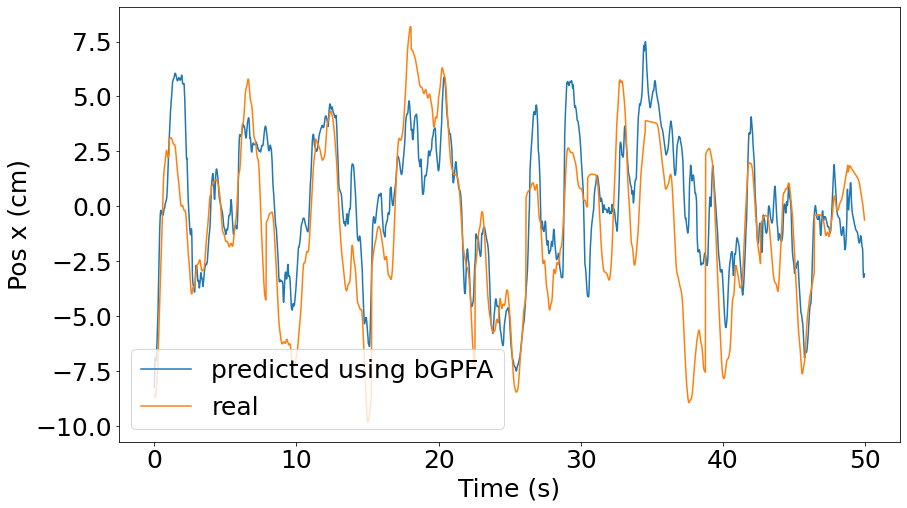

In [19]:
time=0.02*np.arange(len(y_test[0:2500, 0]))
fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_lstm_pcs[0:2500, 0]) 
plt.plot(time, y_test[0:2500, 0])
plt.legend(['predicted using bGPFA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos x (cm)', fontsize=25)
# plt.title('Real & predicted hand position in x for 25% of testing data: \n LSTM based on the latents inferred by bGPFA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LSTM_pos_x_bGPFA.jpeg')

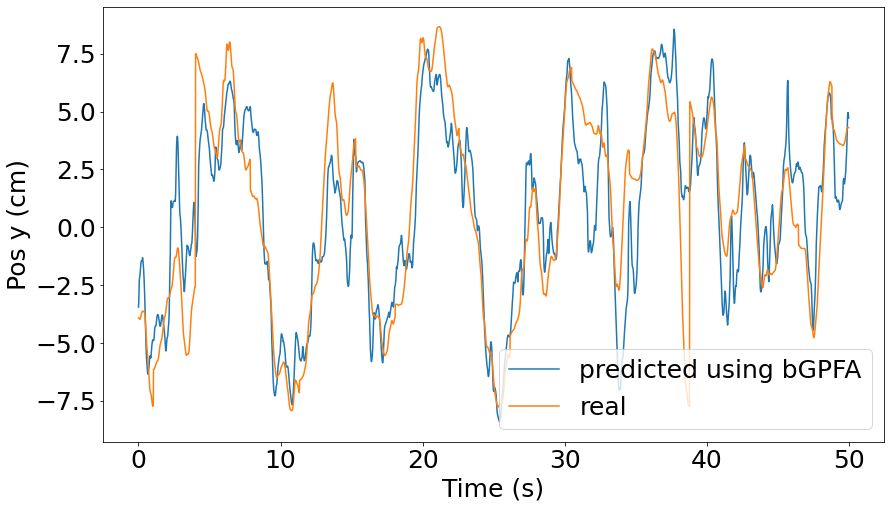

In [20]:
time=0.02*np.arange(len(y_test[0:2500, 0]))
fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_lstm_pcs[0:2500, 1]) 
plt.plot(time, y_test[0:2500, 1])
plt.legend(['predicted using bGPFA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos y (cm)', fontsize=25)
# plt.title('Real & predicted hand position in x for 25% of testing data: \n LSTM based on the latents inferred by bGPFA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('LSTM_pos_y_bGPFA.jpeg')

Text(0.5, 1.0, 'Hand position in x for 25-30% testing data')

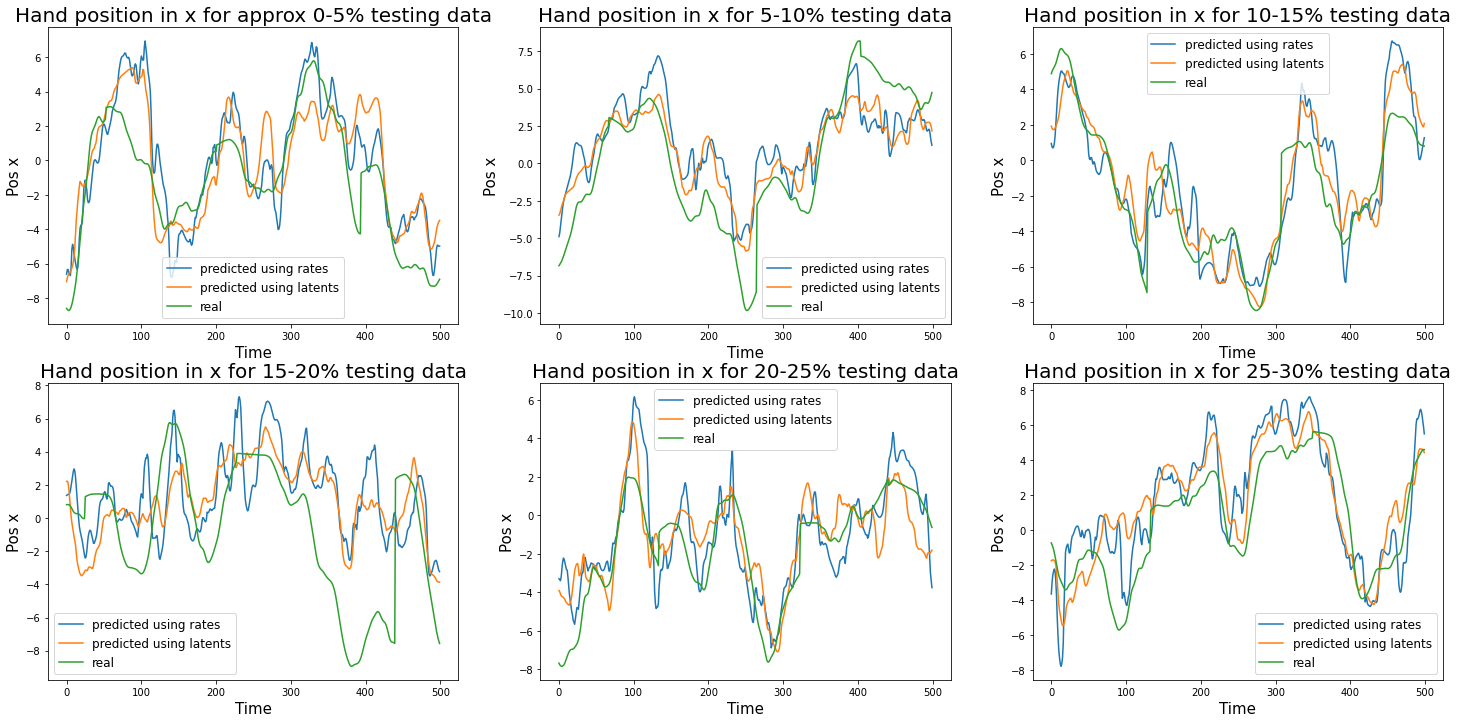

In [68]:
fig, ax = plt.subplots(figsize = (25, 12), nrows=2, ncols=3)
ax[0][0].plot(y_test_predicted_lstm_rates[0:500, 0]) 
ax[0][0].plot(y_test_predicted_lstm_pcs[0:500, 0]) 
ax[0][0].plot(y_test[0:500, 0])
ax[0][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos x', fontsize=15)
ax[0][0].set_title('Hand position in x for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(y_test_predicted_lstm_rates[500:1000, 0]) 
ax[0][1].plot(y_test_predicted_lstm_pcs[500:1000, 0]) 
ax[0][1].plot(y_test[500:1000, 0])
ax[0][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos x', fontsize=15)
ax[0][1].set_title('Hand position in x for 5-10% testing data', fontsize=20)
ax[0][2].plot(y_test_predicted_lstm_rates[1000:1500, 0]) 
ax[0][2].plot(y_test_predicted_lstm_pcs[1000:1500, 0]) 
ax[0][2].plot(y_test[1000:1500, 0])
ax[0][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][2].set_xlabel('Time', fontsize=15)
ax[0][2].set_ylabel('Pos x', fontsize=15)
ax[0][2].set_title('Hand position in x for 10-15% testing data', fontsize=20)
ax[1][0].plot(y_test_predicted_lstm_rates[1500:2000, 0]) 
ax[1][0].plot(y_test_predicted_lstm_pcs[1500:2000, 0]) 
ax[1][0].plot(y_test[1500:2000, 0])
ax[1][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos x', fontsize=15)
ax[1][0].set_title('Hand position in x for 15-20% testing data', fontsize=20)
ax[1][1].plot(y_test_predicted_lstm_rates[2000:2500, 0]) 
ax[1][1].plot(y_test_predicted_lstm_pcs[2000:2500, 0]) 
ax[1][1].plot(y_test[2000:2500, 0])
ax[1][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos x', fontsize=15)
ax[1][1].set_title('Hand position in x for 20-25% testing data', fontsize=20)
ax[1][2].plot(y_test_predicted_lstm_rates[2500:3000, 0]) 
ax[1][2].plot(y_test_predicted_lstm_pcs[2500:3000, 0]) 
ax[1][2].plot(y_test[2500:3000, 0])
ax[1][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][2].set_xlabel('Time', fontsize=15)
ax[1][2].set_ylabel('Pos x', fontsize=15)
ax[1][2].set_title('Hand position in x for 25-30% testing data', fontsize=20)

Text(0.5, 1.0, 'Hand position in y for 25-30% testing data')

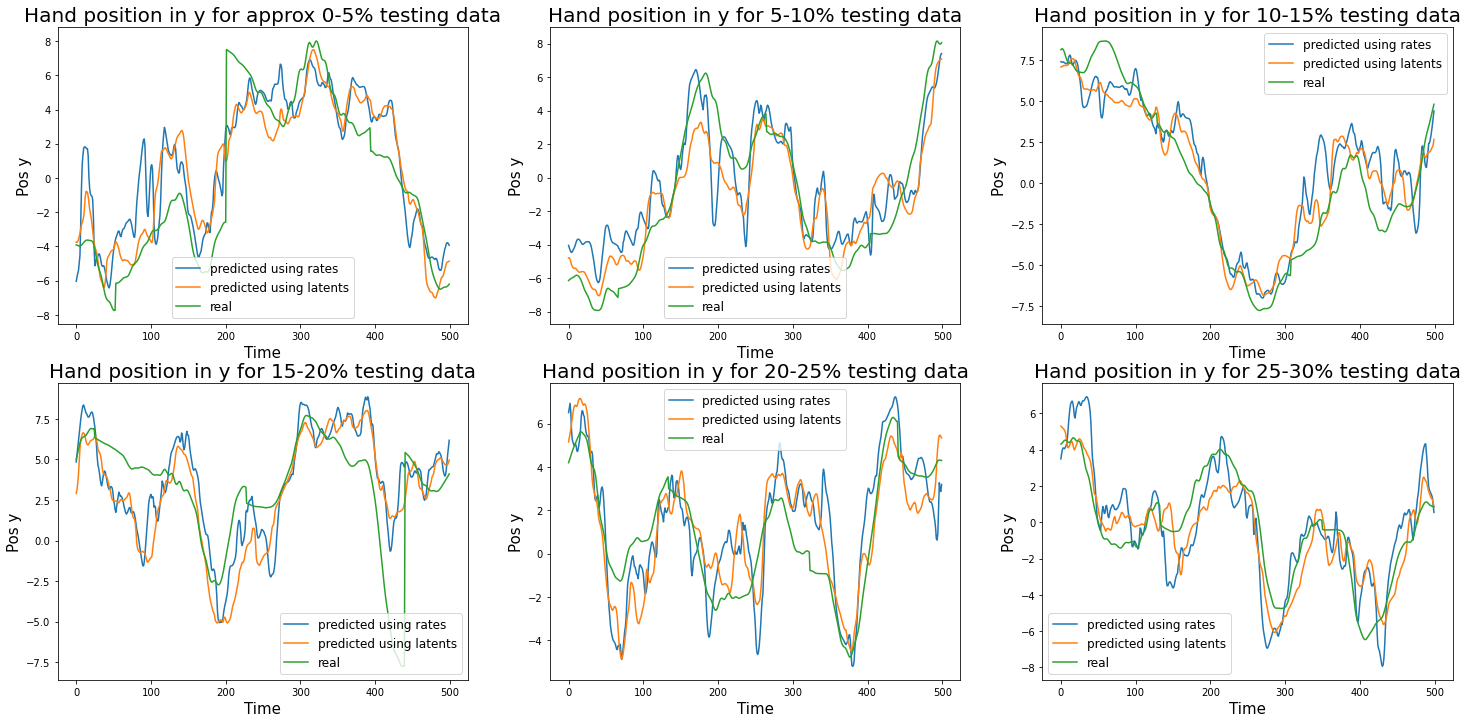

In [69]:
fig, ax = plt.subplots(figsize = (25, 12), nrows=2, ncols=3)
ax[0][0].plot(y_test_predicted_lstm_rates[0:500, 1]) 
ax[0][0].plot(y_test_predicted_lstm_pcs[0:500, 1]) 
ax[0][0].plot(y_test[0:500, 1])
ax[0][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos y', fontsize=15)
ax[0][0].set_title('Hand position in y for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(y_test_predicted_lstm_rates[500:1000, 1]) 
ax[0][1].plot(y_test_predicted_lstm_pcs[500:1000, 1]) 
ax[0][1].plot(y_test[500:1000, 1])
ax[0][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos y', fontsize=15)
ax[0][1].set_title('Hand position in y for 5-10% testing data', fontsize=20)
ax[0][2].plot(y_test_predicted_lstm_rates[1000:1500, 1]) 
ax[0][2].plot(y_test_predicted_lstm_pcs[1000:1500, 1]) 
ax[0][2].plot(y_test[1000:1500, 1])
ax[0][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][2].set_xlabel('Time', fontsize=15)
ax[0][2].set_ylabel('Pos y', fontsize=15)
ax[0][2].set_title('Hand position in y for 10-15% testing data', fontsize=20)
ax[1][0].plot(y_test_predicted_lstm_rates[1500:2000, 1]) 
ax[1][0].plot(y_test_predicted_lstm_pcs[1500:2000, 1]) 
ax[1][0].plot(y_test[1500:2000, 1])
ax[1][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos y', fontsize=15)
ax[1][0].set_title('Hand position in y for 15-20% testing data', fontsize=20)
ax[1][1].plot(y_test_predicted_lstm_rates[2000:2500, 1]) 
ax[1][1].plot(y_test_predicted_lstm_pcs[2000:2500, 1]) 
ax[1][1].plot(y_test[2000:2500, 1])
ax[1][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos y', fontsize=15)
ax[1][1].set_title('Hand position in y for 20-25% testing data', fontsize=20)
ax[1][2].plot(y_test_predicted_lstm_rates[2500:3000, 1]) 
ax[1][2].plot(y_test_predicted_lstm_pcs[2500:3000, 1]) 
ax[1][2].plot(y_test[2500:3000, 1])
ax[1][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][2].set_xlabel('Time', fontsize=15)
ax[1][2].set_ylabel('Pos y', fontsize=15)
ax[1][2].set_title('Hand position in y for 25-30% testing data', fontsize=20)


# DECODING WITH DENSE NN REGRESSION 

USING FIRING RATES AS AN INPUT

In [41]:
model_dense=DenseNNRegression(units=[400, 200], dropout=0.25, num_epochs=5)

In [75]:
scores=[]
train=[]
test=[]
#this splits into trials but beforehand all concatenated - so use both_rates_with_history
for (training, testing) in KFold(10, shuffle=True).split(all_rates_hist): 
    X_train = all_rates_hist_matrix[training,  :]
    X_test = all_rates_hist_matrix[testing, :] 
    Y_train = vel_hist[training, :]
    Y_test = vel_hist[testing, :]
    #testing_vector.append(testing)
    model_dense=DenseNNRegression(units=[400, 200], dropout=0.25, num_epochs=5)
    model_dense.fit(X_train, Y_train)
    y_test_predicted_lstm=model_dense.predict(X_test)
    scores.append(get_R2(Y_test, y_test_predicted_lstm))
    train.append(training)
    test.append(testing)

In [76]:
scores
#                  scores for POSITION
"""[array([0.79598361, 0.82102874]),
 array([0.8021449 , 0.82149298]),
 array([0.7880915, 0.8219288]),
 array([0.79391554, 0.83394957]),
 array([0.80554873, 0.83415808]),
 array([0.80674891, 0.8337715 ]),
 array([0.8135033 , 0.83018149]),
 array([0.8063801 , 0.83885792]),
 array([0.80651555, 0.83808352]),
 array([0.7950294 , 0.82086475])]"""

#                 scores for VELOCITY
"""[array([0.7729091 , 0.77846029]),
 array([0.75459375, 0.77226809]),
 array([0.78267284, 0.76333972]),
 array([0.76387524, 0.77659076]),
 array([0.75715721, 0.77190338]),
 array([0.77341502, 0.7657866 ]),
 array([0.77708726, 0.77476301]),
 array([0.75225288, 0.77209434]),
 array([0.77758269, 0.77091373]),
 array([0.77613616, 0.77602915])]"""

'[array([0.79598361, 0.82102874]),\n array([0.8021449 , 0.82149298]),\n array([0.7880915, 0.8219288]),\n array([0.79391554, 0.83394957]),\n array([0.80554873, 0.83415808]),\n array([0.80674891, 0.8337715 ]),\n array([0.8135033 , 0.83018149]),\n array([0.8063801 , 0.83885792]),\n array([0.80651555, 0.83808352]),\n array([0.7950294 , 0.82086475])]'

In [42]:
cv_Scores_pos_x_rates=[0.79598361, 0.8021449 , 0.7880915, 0.79391554, 0.80554873,
                       0.80674891, 0.8135033 , 0.8063801 , 0.80651555, 0.7950294]
cv_Scores_pos_y_rates=[0.82102874, 0.82149298, 0.8219288, 0.83394957, 0.83415808, 
                       0.8337715, 0.83018149, 0.83885792, 0.83808352, 0.82086475]
cv_Scores_vel_x_rates=[0.7729091 , 0.75459375, 0.78267284, 0.76387524, 0.75715721, 
                       0.77341502, 0.77708726, 0.75225288, 0.77758269, 0.77613616]
cv_Scores_vel_y_rates=[0.77846029, 0.77226809, 0.76333972, 0.77659076, 0.77190338, 
                       0.7657866 , 0.77476301, 0.77209434, 0.77091373, 0.77602915]

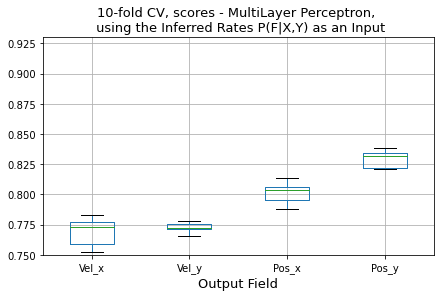

In [43]:
rates_dense = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_Scores_vel_x_rates,
     'Vel_y': cv_Scores_vel_y_rates,
     'Pos_x': cv_Scores_pos_x_rates ,
     'Pos_y': cv_Scores_pos_y_rates ,
    }
pd.set_option('display.max_columns', None)
cv_scores_dense_rates = pd.DataFrame(data=rates_dense)
cv_scores_dense_rates

fig, ax = plt.subplots(figsize = (7, 4))
boxplot_dense_rates = cv_scores_dense_rates.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_dense_rates.set_title('10-fold CV, scores - MultiLayer Perceptron, \n using the Inferred Rates P(F|X,Y) as an Input', fontsize=13)
boxplot_dense_rates.set_ylim([0.75, 0.93])
boxplot_dense_rates.set_xlabel('Output Field', fontsize=13)
plt.savefig('bGPFA_Dense_scores_rates.jpeg')

USING LATENTS AS AN INPUT 

In [84]:
scores=[]
train=[]
test=[]
#this splits into trials but beforehand all concatenated - so use both_rates_with_history
for (training, testing) in KFold(10, shuffle=True).split(all_rates_hist): 
    X_train = all_latents_hist_matrix[training,  :]
    X_test = all_latents_hist_matrix[testing, :] 
    Y_train = locs_hist[training, :]
    Y_test = locs_hist[testing, :]
    #testing_vector.append(testing)
    model_dense=DenseNNRegression(units=[400, 200], dropout=0.25, num_epochs=5)
    model_dense.fit(X_train, Y_train)
    y_test_predicted_lstm=model_dense.predict(X_test)
    scores.append(get_R2(Y_test, y_test_predicted_lstm))
    train.append(training)
    test.append(testing)
    
#             scores for VELOCITY 
"""[array([0.84147252, 0.83981888]),
 array([0.84493773, 0.83200698]),
 array([0.83829659, 0.83086756]),
 array([0.8280362 , 0.83797048]),
 array([0.82668339, 0.82757726]),
 array([0.83389967, 0.82699451]),
 array([0.83839496, 0.83052307]),
 array([0.84568609, 0.8247067 ]),
 array([0.82682146, 0.83800264]),
 array([0.83950234, 0.84115639])]"""

#             scores for POSITION
"""[array([0.90266784, 0.91107405]),
 array([0.90416718, 0.90752551]),
 array([0.89411377, 0.91611816]),
 array([0.91125901, 0.9179606 ]),
 array([0.9040912 , 0.90129072]),
 array([0.91063216, 0.90685204]),
 array([0.90377206, 0.91575266]),
 array([0.8999881, 0.9126864]),
 array([0.90308366, 0.91614336]),
 array([0.90998883, 0.91262264])]"""

'[array([0.84147252, 0.83981888]),\n array([0.84493773, 0.83200698]),\n array([0.83829659, 0.83086756]),\n array([0.8280362 , 0.83797048]),\n array([0.82668339, 0.82757726]),\n array([0.83389967, 0.82699451]),\n array([0.83839496, 0.83052307]),\n array([0.84568609, 0.8247067 ]),\n array([0.82682146, 0.83800264]),\n array([0.83950234, 0.84115639])]'

In [44]:
cv_Scores_pos_x_latents=[0.90266784, 0.90416718, 0.89411377, 0.91125901, 0.9040912 , 
                         0.91063216, 0.90377206, 0.8999881, 0.90308366, 0.90998883]
cv_Scores_pos_y_latents=[0.91107405, 0.90752551, 0.91611816, 0.9179606 , 0.90129072, 
                         0.90685204, 0.91575266, 0.9126864, 0.91614336, 0.91262264]
cv_Scores_vel_x_latents=[0.84147252, 0.84493773, 0.83829659, 0.8280362 , 0.82668339,
                         0.83389967, 0.83839496, 0.84568609, 0.82682146, 0.83950234]
cv_Scores_vel_y_latents=[0.83981888, 0.83200698, 0.83086756, 0.83797048, 0.82757726, 
                         0.82699451, 0.83052307, 0.8247067 , 0.83800264, 0.84115639]

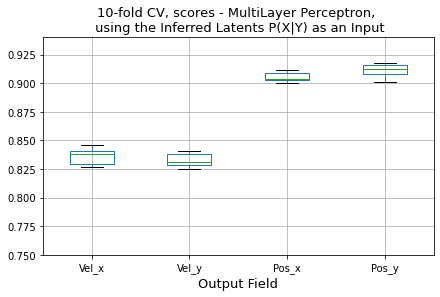

In [45]:
latents_dense = {'K':['1', '2','3','4', '5','6','7', '8','9','10' ], 
     'Vel_x': cv_Scores_vel_x_latents,
     'Vel_y': cv_Scores_vel_y_latents,
     'Pos_x': cv_Scores_pos_x_latents,
     'Pos_y': cv_Scores_pos_y_latents,
    }
pd.set_option('display.max_columns', None)
cv_scores_dense_latents = pd.DataFrame(data=latents_dense)
cv_scores_dense_latents

fig, ax = plt.subplots(figsize = (7, 4))
boxplot_dense_latents = cv_scores_dense_latents.boxplot(column=['Vel_x', 'Vel_y', 'Pos_x',  'Pos_y'], showfliers=False)  
boxplot_dense_latents.set_title('10-fold CV, scores - MultiLayer Perceptron, \n using the Inferred Latents P(X|Y) as an Input', fontsize=13)
boxplot_dense_latents.set_ylim([0.75, 0.94])
boxplot_dense_latents.set_xlabel('Output Field', fontsize=13)
plt.savefig('bGPFA_Dense_scores_latents.jpeg')


In [46]:
mean_scores_dense={'CV':['AVERAGE SCORE'], 
     'Rates-vel_x': np.mean(cv_Scores_vel_x_rates),
     'Rates-vel_y': np.mean(cv_Scores_vel_y_rates),
     'Rates-pos_x': np.mean(cv_Scores_pos_x_rates) ,
     'Rates-pos_y': np.mean(cv_Scores_pos_y_rates) ,
     'Latents-vel_x': np.mean(cv_Scores_vel_x_latents),
     'Latents-vel_y': np.mean(cv_Scores_vel_y_latents),
     'Latents-pos_x': np.mean(cv_Scores_pos_x_latents),
     'Latents-pos_y': np.mean(cv_Scores_pos_y_latents),
    }
pd.set_option('display.max_columns', None)
cv_scores_LSTM_dense = pd.DataFrame(data=mean_scores_dense)
cv_scores_LSTM_dense 

,CV,Rates-vel_x,Rates-vel_y,Rates-pos_x,Rates-pos_y,Latents-vel_x,Latents-vel_y,Latents-pos_x,Latents-pos_y
0,AVERAGE SCORE,0.768768,0.772215,0.801386,0.829432,0.836373,0.832962,0.904376,0.911803


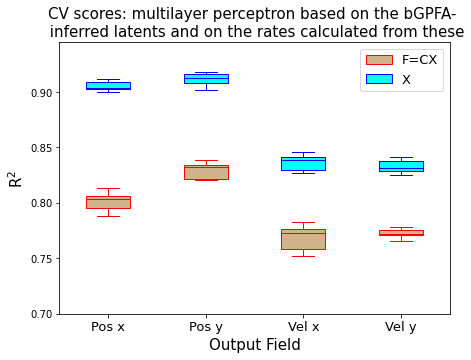

In [47]:

cv_rates_bGPFA_dense= [cv_Scores_pos_x_rates,cv_Scores_pos_y_rates, cv_Scores_vel_x_rates,cv_Scores_vel_y_rates]
cv_latents_bGPFA_dense= [cv_Scores_pos_x_latents,cv_Scores_pos_y_latents, cv_Scores_vel_x_latents,cv_Scores_vel_y_latents]

fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_rates_bGPFA_dense, 'red', 'tan')
bp2 = box_plot(cv_latents_bGPFA_dense, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['F=CX', 'X'], fontsize=13)
ax.set_ylim(0.70, 0.945)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: multilayer perceptron based on the bGPFA- \n inferred latents and on the rates calculated from these', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('APPENDIX_Dense_scores_bGPFA_XvsF.jpeg')

COMPUTING PREDICTIONS 

In [39]:
# Plot predictions 
neural_data= Ypred # T all trials x N
y=locs

#Doing decoding with history ---- LSTM takes into consideration previous time samples 

bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

Y = get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

"""Y_flat ---- Time all trials x (N neurons for all time bins considered) """
# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
Y_flat=Y.reshape(Y.shape[0],(Y.shape[1]*Y.shape[2]))
Y_flat.shape #(100000, 462) Time all trials x Neurons at all time bins  

X_train=Y_flat[10:90000, :] # first elements were NaNs 
y_train=y[10:90000, :] # first elements were NaNs 
X_test=Y_flat[90000:99999, :]
y_test=y[90000:99999, :]

#Fit model - Train model
model_dense.fit(X_train, y_train)

#Test model 
y_test_predicted_dense_rates=model_dense.predict(X_test)
R2s_dense_test_rates=get_R2(y_test, y_test_predicted_dense_rates)
print('R2s:', R2s_dense_test_rates)

R2s: [0.74126018 0.76195879]


In [55]:
# Plot predictions 
X = model.lat_dist.lat_mu.detach().cpu().numpy()[0, ...]
neural_data= X # T all trials x N
y=locs

#Doing decoding with history ---- LSTM takes into consideration previous time samples 

bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding

Y = get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

"""Y_flat ---- Time all trials x (N neurons for all time bins considered) """
# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
Y_flat=Y.reshape(Y.shape[0],(Y.shape[1]*Y.shape[2]))
Y_flat.shape #(100000, 462) Time all trials x Neurons at all time bins  

X_train=Y_flat[10:90000, :] # first elements were NaNs 
y_train=y[10:90000, :] # first elements were NaNs 
X_test=Y_flat[90000:99999, :]
y_test=y[90000:99999, :]

#Fit model - Train model
model_dense.fit(X_train, y_train)

#Test model 
y_test_predicted_dense_latents=model_dense.predict(X_test)
R2s_test_dense_latents=get_R2(y_test, y_test_predicted_dense_latents)
print('R2s:', R2s_test_dense_latents)

2022-06-14 03:33:12.757938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 03:33:12.760347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 03:33:12.760589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 03:33:12.760773: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1953] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 8.6. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2022-06-14 03:33:12.760924: I tensorflow/core/platform/cpu_feature_guard.cc:151] 

R2s: [0.71164024 0.72330256]


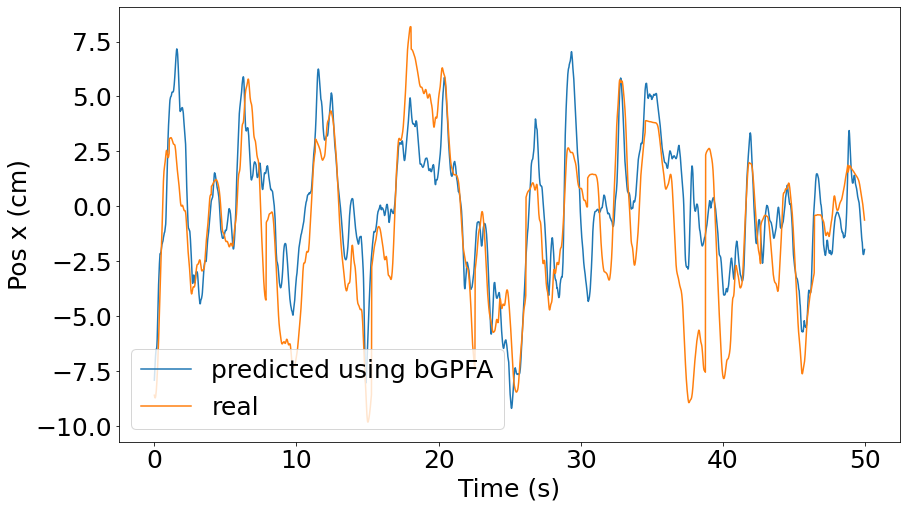

In [58]:
time=0.02*np.arange(len(y_test[0:2500, 0]))
fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_dense_latents[0:2500, 0]) 
plt.plot(time, y_test[0:2500, 0])
plt.legend(['predicted using bGPFA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos x (cm)', fontsize=25)
# plt.title('Real & predicted hand position in x for 25% of testing data: \n multilayer perceptron based on the latents inferred by bGPFA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('Dense_pos_x_bGPFA.jpeg')

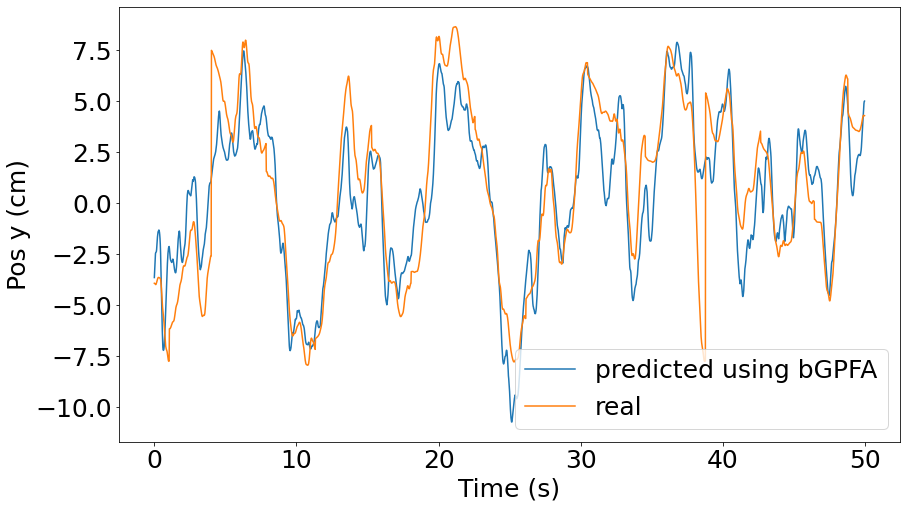

In [59]:
time=0.02*np.arange(len(y_test[0:2500, 0]))
fig, ax = plt.subplots(figsize = (14, 8), nrows=1, ncols=1)
plt.plot(time, y_test_predicted_dense_latents[0:2500, 1]) 
plt.plot(time, y_test[0:2500, 1])
plt.legend(['predicted using bGPFA','real'], fontsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Pos y (cm)', fontsize=25)
# plt.title('Real & predicted hand position in y for 25% of testing data: \n multilayer perceptron based on the latents inferred by bGPFA', fontsize=30)
#tick.label.set_fontsize(14) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('Dense_pos_y_bGPFA.jpeg')

Text(0.5, 1.0, 'Hand position in x for 25-30% testing data')

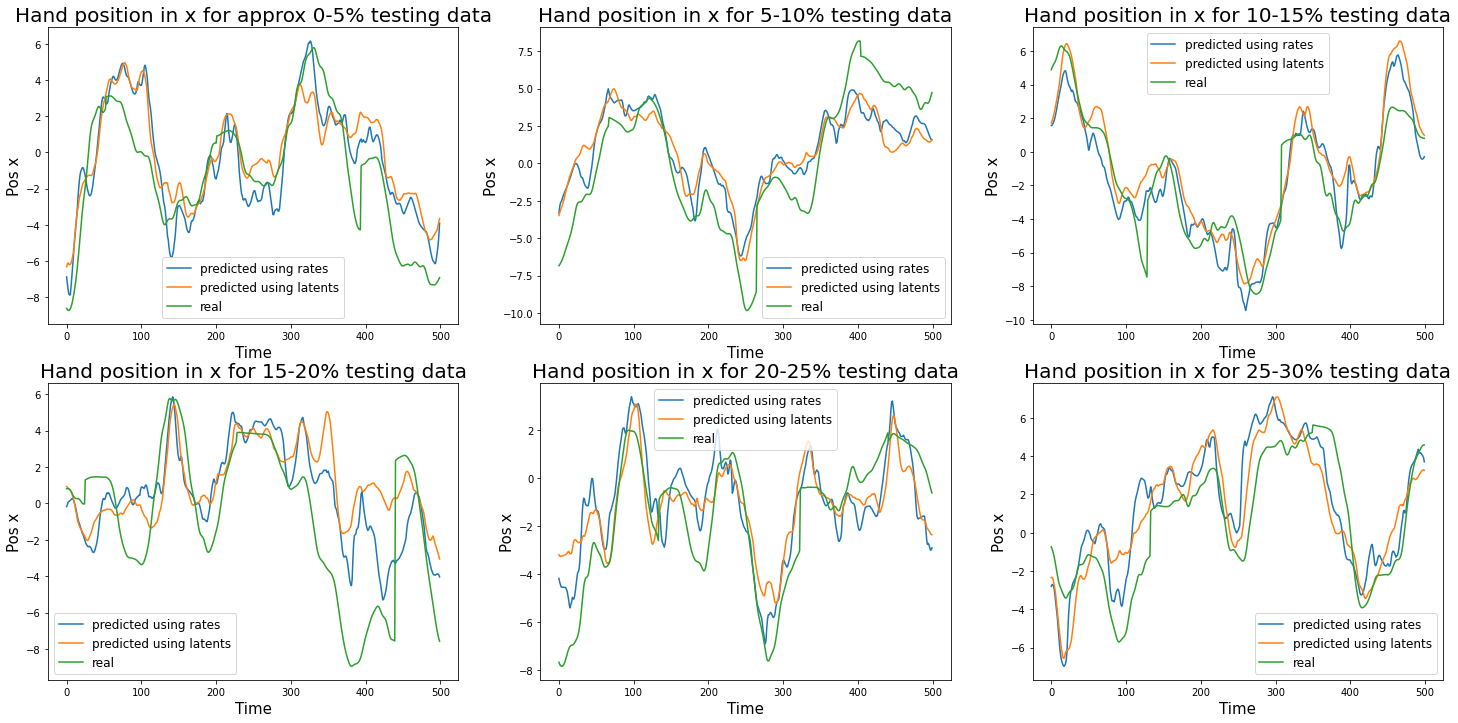

In [101]:
fig, ax = plt.subplots(figsize = (25, 12), nrows=2, ncols=3)
ax[0][0].plot(y_test_predicted_dense_rates[0:500, 0]) 
ax[0][0].plot(y_test_predicted_dense_latents[0:500, 0]) 
ax[0][0].plot(y_test[0:500, 0])
ax[0][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos x', fontsize=15)
ax[0][0].set_title('Hand position in x for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(y_test_predicted_dense_rates[500:1000, 0]) 
ax[0][1].plot(y_test_predicted_dense_latents[500:1000, 0]) 
ax[0][1].plot(y_test[500:1000, 0])
ax[0][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos x', fontsize=15)
ax[0][1].set_title('Hand position in x for 5-10% testing data', fontsize=20)
ax[0][2].plot(y_test_predicted_dense_rates[1000:1500, 0]) 
ax[0][2].plot(y_test_predicted_dense_latents[1000:1500, 0]) 
ax[0][2].plot(y_test[1000:1500, 0])
ax[0][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][2].set_xlabel('Time', fontsize=15)
ax[0][2].set_ylabel('Pos x', fontsize=15)
ax[0][2].set_title('Hand position in x for 10-15% testing data', fontsize=20)
ax[1][0].plot(y_test_predicted_dense_rates[1500:2000, 0]) 
ax[1][0].plot(y_test_predicted_dense_latents[1500:2000, 0]) 
ax[1][0].plot(y_test[1500:2000, 0])
ax[1][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos x', fontsize=15)
ax[1][0].set_title('Hand position in x for 15-20% testing data', fontsize=20)
ax[1][1].plot(y_test_predicted_dense_rates[2000:2500, 0]) 
ax[1][1].plot(y_test_predicted_dense_latents[2000:2500, 0]) 
ax[1][1].plot(y_test[2000:2500, 0])
ax[1][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos x', fontsize=15)
ax[1][1].set_title('Hand position in x for 20-25% testing data', fontsize=20)
ax[1][2].plot(y_test_predicted_dense_rates[2500:3000, 0]) 
ax[1][2].plot(y_test_predicted_dense_latents[2500:3000, 0]) 
ax[1][2].plot(y_test[2500:3000, 0])
ax[1][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][2].set_xlabel('Time', fontsize=15)
ax[1][2].set_ylabel('Pos x', fontsize=15)
ax[1][2].set_title('Hand position in x for 25-30% testing data', fontsize=20)

Text(0.5, 1.0, 'Hand position in y for 25-30% testing data')

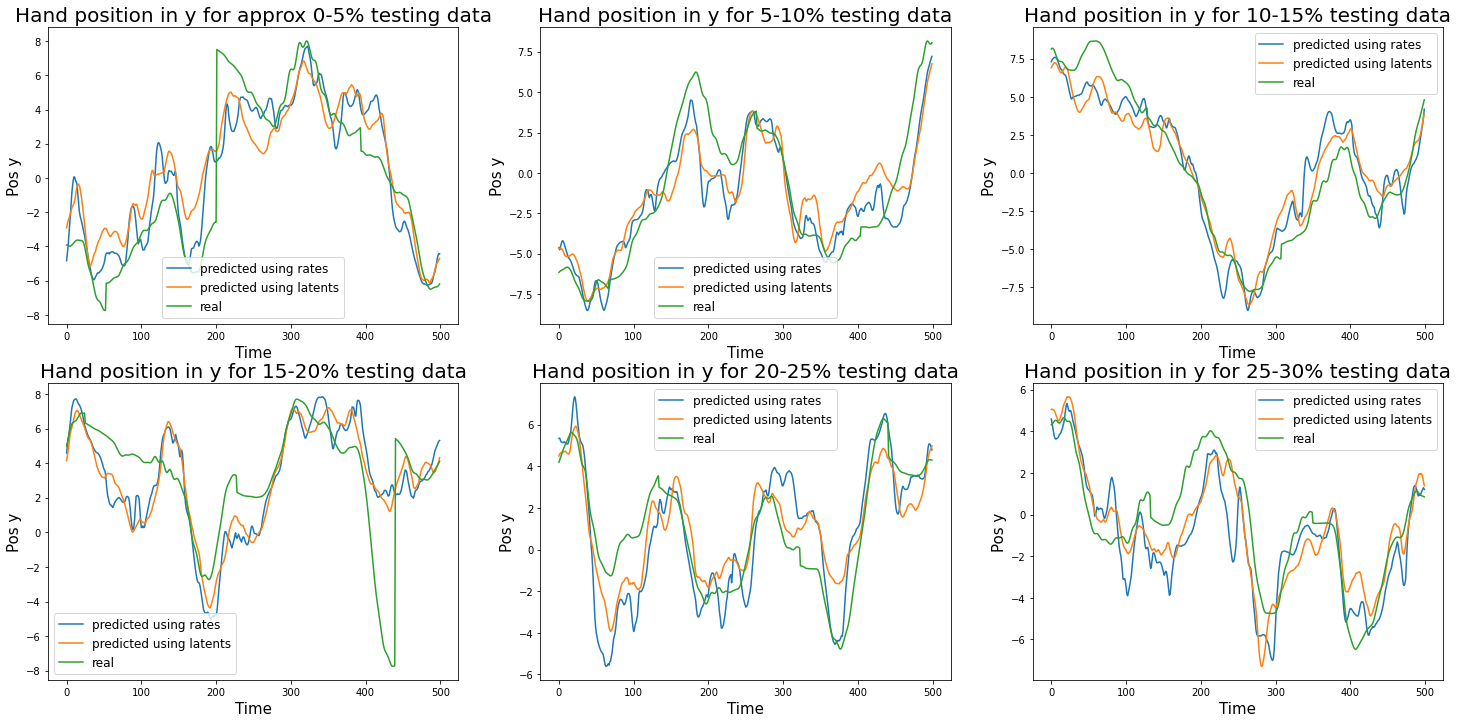

In [102]:
fig, ax = plt.subplots(figsize = (25, 12), nrows=2, ncols=3)
ax[0][0].plot(y_test_predicted_dense_rates[0:500, 1]) 
ax[0][0].plot(y_test_predicted_dense_latents[0:500, 1]) 
ax[0][0].plot(y_test[0:500, 1])
ax[0][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][0].set_xlabel('Time', fontsize=15)
ax[0][0].set_ylabel('Pos y', fontsize=15)
ax[0][0].set_title('Hand position in y for approx 0-5% testing data', fontsize=20)
ax[0][1].plot(y_test_predicted_dense_rates[500:1000, 1]) 
ax[0][1].plot(y_test_predicted_dense_latents[500:1000, 1]) 
ax[0][1].plot(y_test[500:1000, 1])
ax[0][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][1].set_xlabel('Time', fontsize=15)
ax[0][1].set_ylabel('Pos y', fontsize=15)
ax[0][1].set_title('Hand position in y for 5-10% testing data', fontsize=20)
ax[0][2].plot(y_test_predicted_dense_rates[1000:1500, 1]) 
ax[0][2].plot(y_test_predicted_dense_latents[1000:1500, 1]) 
ax[0][2].plot(y_test[1000:1500, 1])
ax[0][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[0][2].set_xlabel('Time', fontsize=15)
ax[0][2].set_ylabel('Pos y', fontsize=15)
ax[0][2].set_title('Hand position in y for 10-15% testing data', fontsize=20)
ax[1][0].plot(y_test_predicted_dense_rates[1500:2000, 1]) 
ax[1][0].plot(y_test_predicted_dense_latents[1500:2000, 1]) 
ax[1][0].plot(y_test[1500:2000, 1])
ax[1][0].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][0].set_xlabel('Time', fontsize=15)
ax[1][0].set_ylabel('Pos y', fontsize=15)
ax[1][0].set_title('Hand position in y for 15-20% testing data', fontsize=20)
ax[1][1].plot(y_test_predicted_dense_rates[2000:2500, 1]) 
ax[1][1].plot(y_test_predicted_dense_latents[2000:2500, 1]) 
ax[1][1].plot(y_test[2000:2500, 1])
ax[1][1].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][1].set_xlabel('Time', fontsize=15)
ax[1][1].set_ylabel('Pos y', fontsize=15)
ax[1][1].set_title('Hand position in y for 20-25% testing data', fontsize=20)
ax[1][2].plot(y_test_predicted_dense_rates[2500:3000, 1]) 
ax[1][2].plot(y_test_predicted_dense_latents[2500:3000, 1]) 
ax[1][2].plot(y_test[2500:3000, 1])
ax[1][2].legend(['predicted using rates','predicted using latents', 'real'], fontsize=12)
ax[1][2].set_xlabel('Time', fontsize=15)
ax[1][2].set_ylabel('Pos y', fontsize=15)
ax[1][2].set_title('Hand position in y for 25-30% testing data', fontsize=20)


COMPARING LSTM TO PERCEPTRON 

In [48]:
# scores using the firing rates from the data 

cv_vel_x_rates_LSTM=[0.95597108,0.95001408,0.95340578,0.94936236,0.95595663,0.95581072,0.95881756,
                  0.95120518,0.95268704,0.95114964]
cv_vel_y_rates_LSTM=[0.95097876, 0.94883948, 0.95012732, 0.94690591, 0.95220971, 0.94763706, 0.95055216, 
                  0.94630818, 0.95205219, 0.94769666]
cv_pos_x_rates_LSTM=[0.97745602, 0.97567137, 0.97580711, 0.97434582, 0.9749096 , 0.97575527, 0.97359311, 
                   0.97334644, 0.97756795, 0.97686266]
cv_pos_y_rates_LSTM=[0.97748025, 0.97849039, 0.97772142, 0.9791986, 0.97875781, 0.97805503, 0.97772923,
                   0.97805531, 0.97994865, 0.9813002]

cv_vel_x_pcs_LSTM=[0.96255548, 0.95973464, 0.9598874 , 0.96243119, 0.96090319, 0.96223392, 0.96197628, 
                          0.96100978, 0.96276608, 0.96212506]
cv_vel_y_pcs_LSTM=[0.95776219, 0.95696231, 0.95811964, 0.95990905, 0.9609399 , 0.95951015, 
                          0.95792669, 0.95902386, 0.96056491, 0.9569561]
cv_pos_x_pcs_LSTM=[0.97974532, 0.97808459, 0.97886193, 0.97954095, 0.97861696, 0.97881041, 
                          0.97956185, 0.98063652, 0.97905856, 0.97960072]
cv_pos_y_pcs_LSTM=[0.9807244 , 0.98005306, 0.98177455, 0.98014698, 0.98126859, 0.98143323, 
                          0.98209167, 0.9821061 , 0.9820066 , 0.98064705]

cv_vel_x_rates_dense=[0.80441954, 0.79928293, 0.80357315, 0.81350946, 0.80898845, 0.78428285, 
                0.82245284, 0.82039151, 0.7824337 , 0.81587852]
cv_vel_y_rates_dense=[0.81500518, 0.81888135, 0.75859067, 0.81360276, 0.81469663, 0.81696609, 
                0.81211475, 0.82218446, 0.80848091, 0.80730602]
cv_pos_x_rates_dense=[0.8233847 , 0.82906518, 0.82345953, 0.82028517, 0.82678134, 0.81013378, 
                0.82723866, 0.83613947, 0.83983654, 0.82735873]
cv_pos_y_rates_dense=[0.84024272, 0.83561525, 0.83405889, 0.84231822, 0.84800925, 0.84162517, 
                0.84535497, 0.84556877, 0.84294712, 0.84398514]

cv_vel_x_pcs_dense=[0.80799383, 0.80436695, 0.81738748, 0.79559023, 0.80233594, 0.78571621, 
              0.79753201, 0.80495206, 0.80838966, 0.80580045]
cv_vel_y_pcs_dense=[0.80455076, 0.78880083, 0.79638452, 0.78943257, 0.81037752, 0.80227519, 
              0.79149323, 0.80432656, 0.79291125, 0.795676 ]
cv_pos_x_pcs_dense=[0.75607866, 0.73734639, 0.76155067, 0.75910278, 0.74834655, 0.75275754, 
              0.75673328, 0.7659472, 0.7507867 , 0.75227577]
cv_pos_y_pcs_dense=[0.77024936, 0.7794667 , 0.78134116, 0.79755761, 0.77641576, 0.78696633, 
              0.78504122, 0.7576299, 0.78901215, 0.79893567]

cv_rates_LSTM = [cv_pos_x_rates_LSTM, cv_pos_y_rates_LSTM, cv_vel_x_rates_LSTM, cv_vel_y_rates_LSTM]
cv_PCA_LSTM = [cv_pos_x_pcs_LSTM, cv_pos_y_pcs_LSTM, cv_vel_x_pcs_LSTM, cv_vel_y_pcs_LSTM]
cv_bGPFA_LSTM = [cv_scores_pos_x_latents, cv_scores_pos_y_latents, cv_scores_vel_x_latents, cv_scores_vel_y_latents]

cv_rates_Dense = [cv_pos_x_rates_dense, cv_pos_y_rates_dense, cv_vel_x_rates_dense, cv_vel_y_rates_dense]
cv_PCA_Dense = [cv_pos_x_pcs_dense, cv_pos_y_pcs_dense, cv_vel_x_pcs_dense, cv_vel_y_pcs_dense]
cv_bGPFA_Dense = [cv_Scores_pos_x_latents, cv_Scores_pos_y_latents, cv_Scores_vel_x_latents, cv_Scores_vel_y_latents]


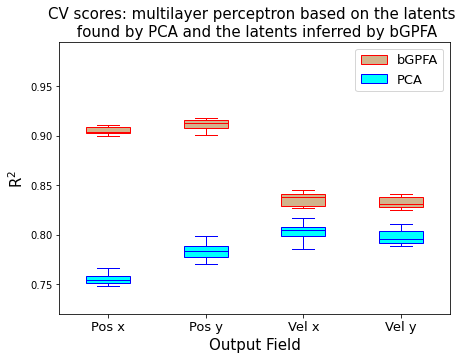

In [49]:
fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_bGPFA_Dense, 'red', 'tan')
bp2 = box_plot(cv_PCA_Dense, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['bGPFA', 'PCA'], fontsize=13)
ax.set_ylim(0.72, 0.995)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: multilayer perceptron based on the latents \n found by PCA and the latents inferred by bGPFA', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('Dense_scores_bGPFAvsPCA.jpeg')

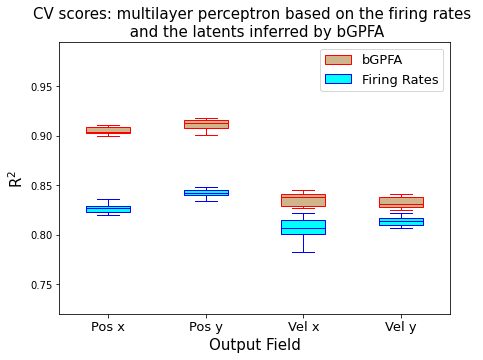

In [50]:
fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_bGPFA_Dense, 'red', 'tan')
bp2 = box_plot(cv_rates_Dense, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['bGPFA', 'Firing Rates'], fontsize=13)
ax.set_ylim(0.72, 0.995)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: multilayer perceptron based on the firing rates \n and the latents inferred by bGPFA', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('Dense_scores_bGPFAvsRates.jpeg')

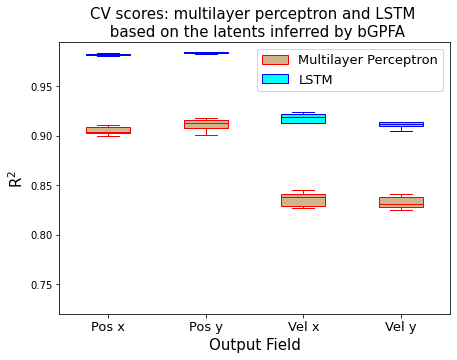

In [51]:
fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_bGPFA_Dense, 'red', 'tan')
bp2 = box_plot(cv_bGPFA_LSTM, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Multilayer Perceptron', 'LSTM'], fontsize=13)
ax.set_ylim(0.72, 0.995)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: multilayer perceptron and LSTM \n based on the latents inferred by bGPFA', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('DensevsLSTM_bGPFA_scores.jpeg')

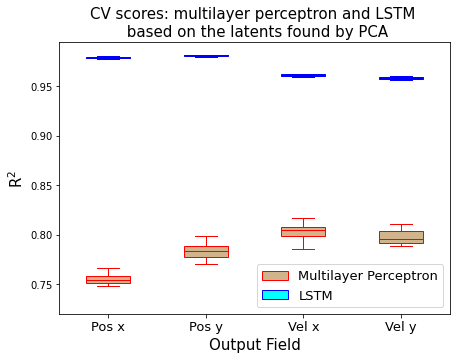

In [52]:
fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_PCA_Dense, 'red', 'tan')
bp2 = box_plot(cv_PCA_LSTM, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Multilayer Perceptron', 'LSTM'], fontsize=13)
ax.set_ylim(0.72, 0.995)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: multilayer perceptron and LSTM \n based on the latents found by PCA', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('DensevsLSTM_PCA_scores.jpeg')

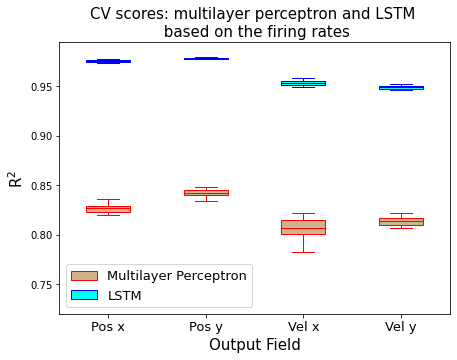

In [53]:
fig, ax = plt.subplots(figsize = (7, 5))
bp1 = box_plot(cv_rates_Dense, 'red', 'tan')
bp2 = box_plot(cv_rates_LSTM, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Multilayer Perceptron', 'LSTM'], fontsize=13)
ax.set_ylim(0.72, 0.995)
ax.set_ylabel('R$^2$', fontsize=15)
ax.set_xlabel('Output Field', fontsize=15)
ax.set_title('CV scores: multilayer perceptron and LSTM \n based on the firing rates', fontsize=15)
# plt.set_xticks(['posx', 'posy', 'velx', 'vely'])
plt.xticks([1, 2, 3, 4], ['Pos x', 'Pos y', 'Vel x', 'Vel y'], fontsize=13)
plt.savefig('DensevsLSTM_rates_scores.jpeg')